In [29]:
# Import necessary libraries
import zipfile
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [2]:
# Connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to zip file on Google Drive
zip_file_path = "/content/drive/MyDrive/animals.zip"

# Unzip the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
# Path to train and val files
train_path = r"/content/animals/train"
val_path = r"/content/animals/val"

In [6]:
# Dictionary labels
labels = {'cat': 0, 'cow': 1, 'dog': 2, 'elephant': 3, 'penguin': 4}
NUM_CLASSES = len(labels)

# Function to read images and labels from a directory
def load_data_from_directory(directory_path):
    images = []
    labels_list = []

    for label_name, label in labels.items():
        folder_path = os.path.join(directory_path, label_name)
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            image = cv2.imread(file_path)
            if image is not None:
                # Thay đổi kích thước ảnh thành 224x224
                image = cv2.resize(image, (224, 224))
                images.append(image)
                labels_list.append(label)

    return np.array(images), np.array(labels_list)

# Update data again
train_images, train_labels = load_data_from_directory(train_path)
test_images, test_labels = load_data_from_directory(val_path)

# Convert labels to one-hot encoded format
train_labels_one_hot = to_categorical(train_labels, NUM_CLASSES)
test_labels_one_hot = to_categorical(test_labels, NUM_CLASSES)

# Check the dataset size
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels_one_hot.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels_one_hot.shape}")

Train images shape: (7575, 224, 224, 3)
Train labels shape: (7575, 5)
Test images shape: (2520, 224, 224, 3)
Test labels shape: (2520, 5)


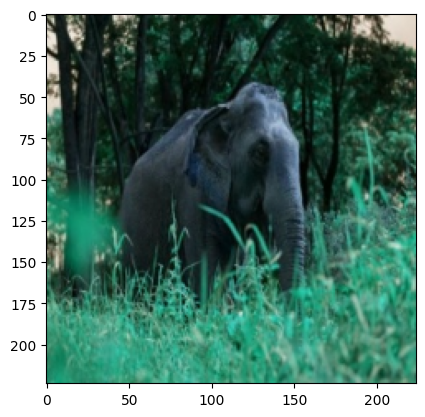

In [12]:
# Shows random images from train sets
plt.imshow(train_images[random.randint(0, len(train_images)+1), :])
plt.show()

In [13]:
# Build model
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.layers[0].trainable = True

94765736/94765736 [==============================] - 5s 0us/step


In [16]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23597957 (90.02 MB)
Trainable params: 23544837 (89.82 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [21]:
# Use Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [23]:
# Train the model
train_model = model.fit(
    train_images, train_labels_one_hot,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(test_images, test_labels_one_hot),
    callbacks=[early_stopping]
)

Epoch 1/10
237/237 [==============================] - 93s 370ms/step - loss: 0.7143 - accuracy: 0.8887 - val_loss: 0.5154 - val_accuracy: 0.8226
Epoch 2/10
237/237 [==============================] - 87s 369ms/step - loss: 1.3532 - accuracy: 0.7901 - val_loss: 4.2328 - val_accuracy: 0.3631
Epoch 3/10
237/237 [==============================] - 84s 356ms/step - loss: 0.6377 - accuracy: 0.8383 - val_loss: 0.8870 - val_accuracy: 0.7341
Epoch 4/10
237/237 [==============================] - 87s 368ms/step - loss: 0.1553 - accuracy: 0.9485 - val_loss: 0.2300 - val_accuracy: 0.9313
Epoch 5/10
237/237 [==============================] - 85s 357ms/step - loss: 0.0983 - accuracy: 0.9681 - val_loss: 0.1781 - val_accuracy: 0.9373
Epoch 6/10
237/237 [==============================] - 84s 356ms/step - loss: 0.0755 - accuracy: 0.9741 - val_loss: 0.1238 - val_accuracy: 0.9587
Epoch 7/10
237/237 [==============================] - 87s 368ms/step - loss: 0.0716 - accuracy: 0.9753 - val_loss: 0.3052 - val_ac

In [28]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot, verbose=1)

# Print out the precision and loss on the test set
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


79/79 [==============================] - 7s 91ms/step - loss: 0.5202 - accuracy: 0.8782
Test Loss: 0.520197868347168
Test Accuracy: 0.8781746029853821


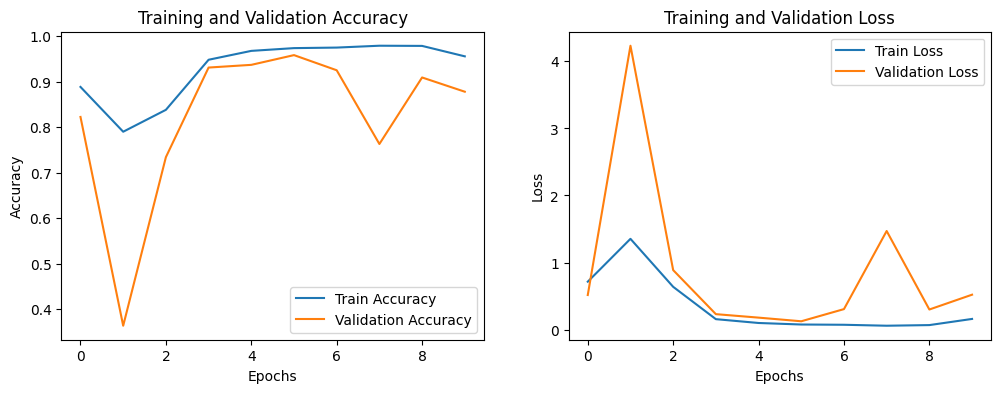

In [25]:
# Plot accuracy and loss
def plot_training_history(history):
    # accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_training_history(train_model)

1/1 [==============================] - 0s 22ms/step


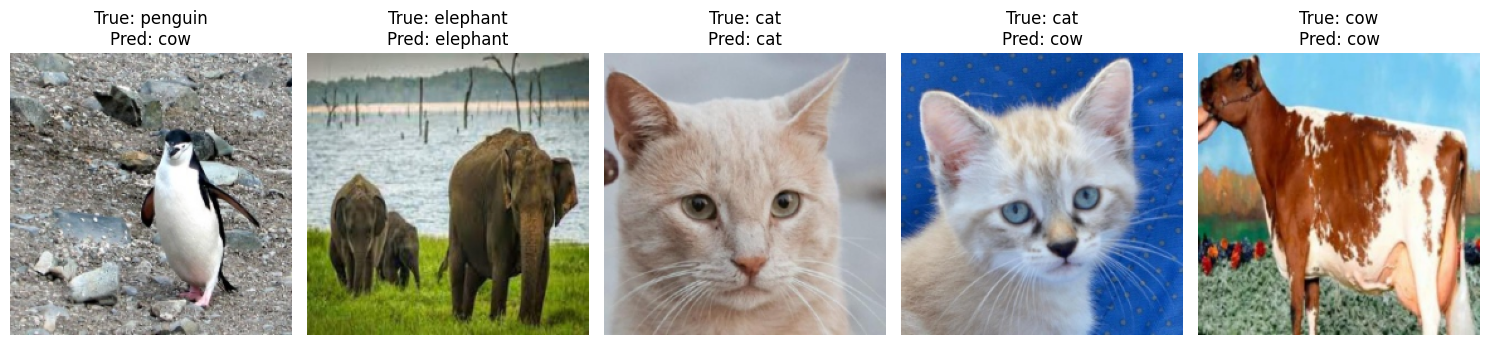

In [27]:
# random prediction function
def plot_random_predictions(model, images, labels, label_dict, num_predictions=5):
    # Randomly select some image indexes
    random_indices = random.sample(range(len(images)), num_predictions)

    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(random_indices):
        image = images[idx]
        true_label = labels[idx]
        # Predict image labels
        prediction = model.predict(np.expand_dims(image, axis=0))
        predicted_label = np.argmax(prediction, axis=1)[0]

        # Convert labels from numbers to label names
        true_label_name = list(label_dict.keys())[list(label_dict.values()).index(true_label)]
        predicted_label_name = list(label_dict.keys())[list(label_dict.values()).index(predicted_label)]

        # Displays images along with actual and predicted labels
        plt.subplot(1, num_predictions, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"True: {true_label_name}\nPred: {predicted_label_name}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Random prediction
plot_random_predictions(model, test_images, test_labels, labels, num_predictions=5)
